In [130]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, ShapleyKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False
ylim = [0., 1.]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The model

In [131]:
dim = 2
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
theta = [0.3]
model.copula_parameters = theta

In [223]:
if True:
    dim = 3
    beta = None
    model = AdditiveGaussian(dim=dim, beta=beta)
    model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
    theta = [0., 0., 0.5]
    model.copula_parameters = theta

## Sobol indices with a classical Monte-Carlo sampling

In [224]:
#ot.RandomGenerator.SetSeed(0)
#np.random.seed(0)
n_perms = None
Nv = 200
No = 100
Ni = 10

# Evaluate the model
shapley = ShapleyIndices(model.input_distribution)
shapley.build_mc_sample(model=model, n_perms=n_perms, Nv=Nv, No=No, Ni=Ni)

In [225]:
n_boot = 1000
shapley_results = shapley.compute_indices(n_boot=n_boot)

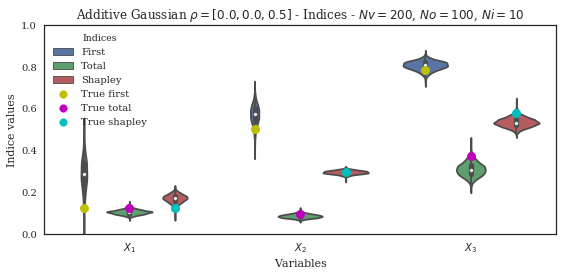

In [226]:
shapley_results.true_first_indices = model.first_order_sobol_indices
shapley_results.true_total_indices = model.total_sobol_indices
shapley_results.true_shapley_indices = model.shapley_indices
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapley_additive_gaussian.pdf')

In [227]:
def get_confidence_interval(results, quantiles=[2.5, 97.5]):
    """
    """
    interval = 2*results[:, 0].T - np.percentile(results, quantiles[::-1], axis=1)
    return interval.T

In [228]:
get_confidence_interval(shapley_results.full_shapley_indices)

array([[ 0.13993419,  0.21526072],
       [ 0.28080909,  0.3148296 ],
       [ 0.48030658,  0.56773039]])

In [229]:
get_confidence_interval(shapley_results.full_first_indices)

array([[ 0.15696256,  0.46626186],
       [ 0.498231  ,  0.68197432],
       [ 0.77159583,  0.85394471]])

In [230]:
get_confidence_interval(shapley_results.full_total_indices)

array([[ 0.07929665,  0.12259561],
       [ 0.06346925,  0.09963542],
       [ 0.23227588,  0.35795926]])

## Kriging Model

In [231]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 10
basis = 'quadratic'
kernel = 'matern'
library = 'sklearn'
sampling = 'monte-carlo'
shapley_kriging = ShapleyKrigingIndices(model.input_distribution)
meta_model = shapley_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library,
                                             sampling=sampling)

In [232]:
n_sample_cv = 10000
score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='monte-carlo')
print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

Cross Validation Q2 score with 10000 observations: 0.870494479329


In [233]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
Nv = 200
No = 100
Ni = 10
n_realization = 300

# Evaluate the kriging model
shapley_kriging.build_mc_sample(model=meta_model, n_perms=None, Nv=Nv, No=No, Ni=Ni, n_realization=n_realization)

Sample size is too large. A loop is done to save memory.
1525
i_p: 0
i_p: 1
i_p: 2
i_p: 3
i_p: 4
i_p: 5
i_p: 6
i_p: 7
Wall time: 16 s


In [234]:
n_boot = 1000
shapley_kriging_results = shapley_kriging.compute_indices(n_boot=n_boot)

In [235]:
shapley_kriging_results.true_first_indices = model.first_order_sobol_indices
shapley_kriging_results.true_total_indices = model.total_sobol_indices
shapley_kriging_results.true_shapley_indices = model.shapley_indices

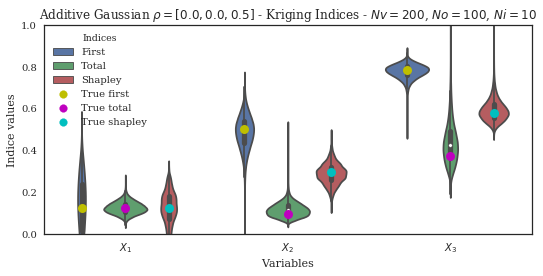

In [236]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_kriging_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapleyGP_additive_gaussian.pdf')

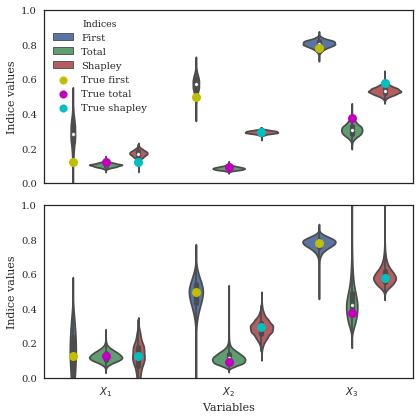

In [237]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_xlabel('')
ax.set_ylim(ylim)

ax = axes[1]
plot_sensitivity_results(shapley_kriging_results, indice='all', ax=ax)
ax.set_ylim(ylim)
ax.legend([])
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapleyGP_additive_gaussian.pdf')

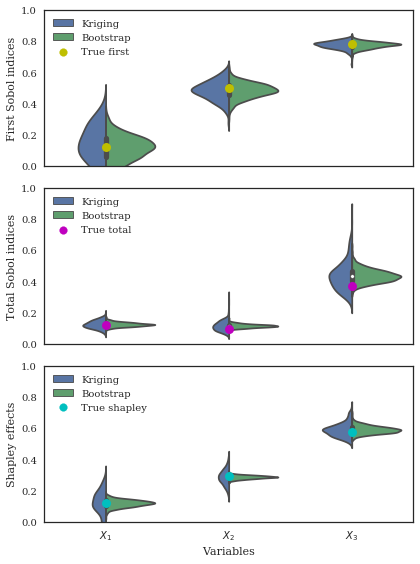

In [239]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_kriging_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(shapley_kriging_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(shapley_kriging_results, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapleyGP_boot_gp_errors_additive_gaussian.pdf')